<a href="https://colab.research.google.com/github/gschamika/study-squad-models/blob/main/word_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 13.jpg to 13 (1).jpg


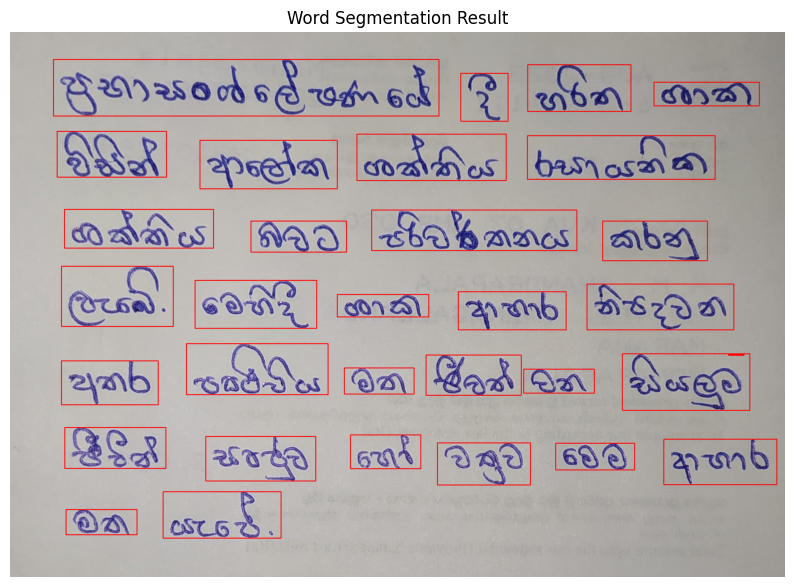

Word bounding boxes in reading order (x, y, w, h):
  Word 1: x=141, y=89, w=1255, h=184
  Word 2: x=1467, y=134, w=154, h=156
  Word 3: x=1685, y=106, w=336, h=152
  Word 4: x=2096, y=163, w=343, h=77
  Word 5: x=153, y=323, w=356, h=149
  Word 6: x=618, y=352, w=447, h=158
  Word 7: x=1129, y=332, w=486, h=151
  Word 8: x=1684, y=337, w=611, h=142
  Word 9: x=177, y=577, w=485, h=126
  Word 10: x=784, y=615, w=311, h=101
  Word 11: x=1177, y=579, w=668, h=132
  Word 12: x=1929, y=615, w=341, h=129
  Word 13: x=167, y=762, w=364, h=196
  Word 14: x=602, y=808, w=396, h=156
  Word 15: x=1065, y=854, w=298, h=73
  Word 16: x=1459, y=845, w=351, h=124
  Word 17: x=1878, y=820, w=478, h=149
  Word 18: x=167, y=1070, w=315, h=143
  Word 19: x=574, y=1014, w=461, h=166
  Word 20: x=1088, y=1093, w=227, h=85
  Word 21: x=1354, y=1051, w=310, h=131
  Word 22: x=1672, y=1097, w=230, h=78
  Word 23: x=1993, y=1047, w=415, h=184
  Word 24: x=2339, y=1049, w=50, h=3
  Word 25: x=178, y=1287, w=329

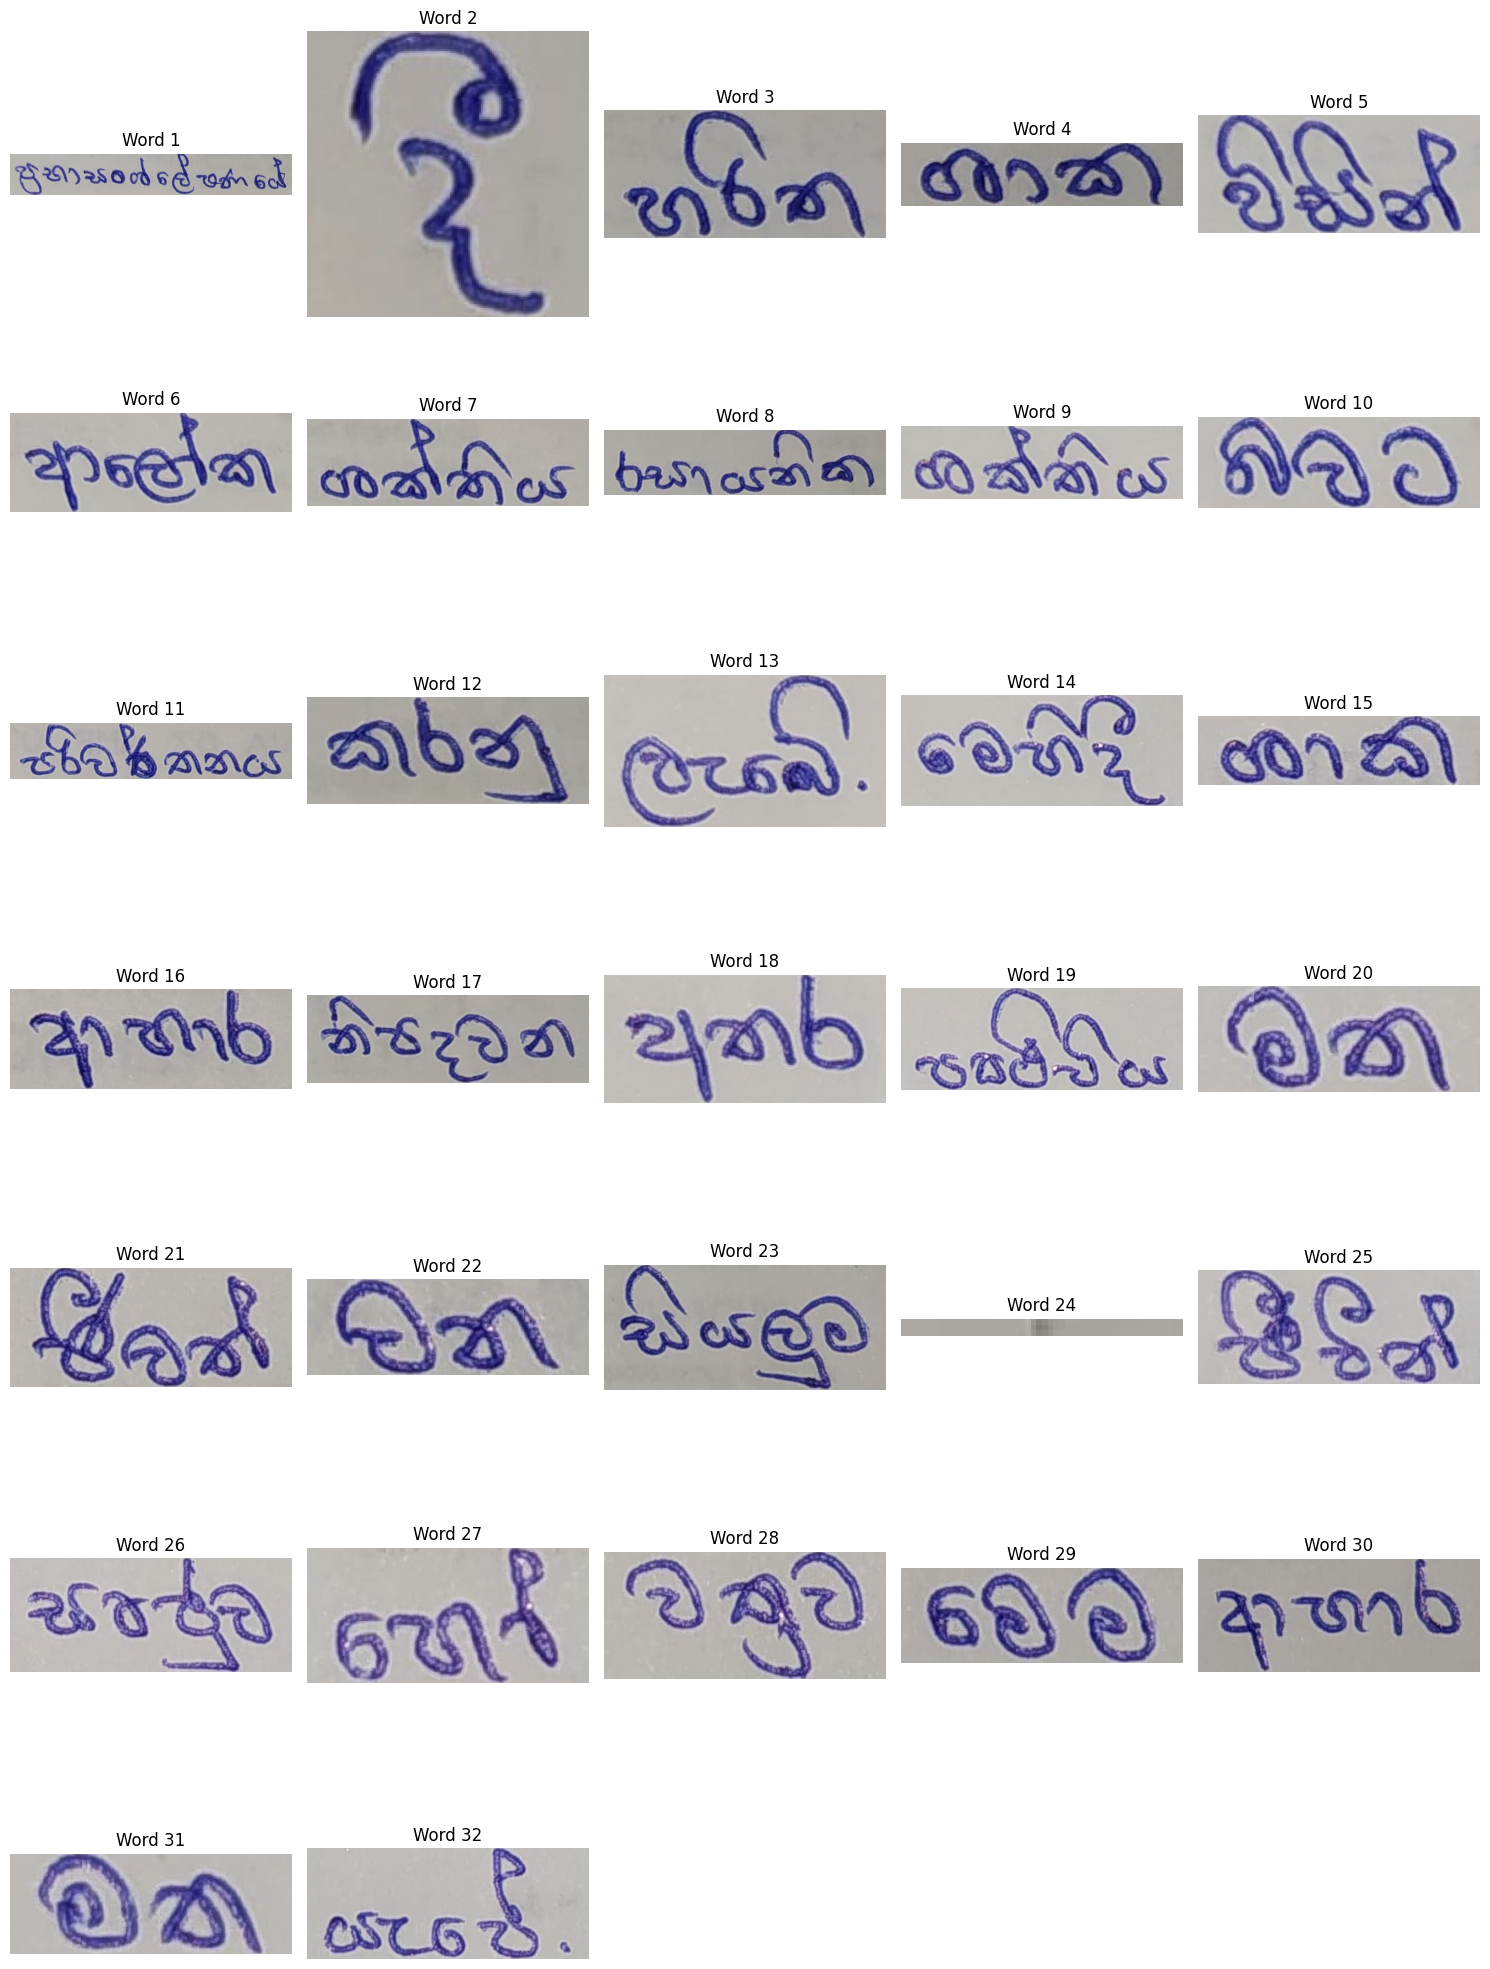

In [ ]:
# ======================================
#  STEP 0: IMPORTS + FILE UPLOAD
# ======================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Let user upload the image
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]

# Read the image via OpenCV
original_img = cv2.imread(image_filename)
if original_img is None:
    raise ValueError("Image not loaded. Please check the file name or path.")

# ======================================
#  STEP 1: WORD SEGMENTATION
# ======================================
def segment_words(image):
    """Convert to grayscale, threshold, dilate, and find word contours."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Tune kernel width based on word spacing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 3))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_annotated = image.copy()
    word_bboxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(word_annotated, (x, y), (x + w, y + h), (0, 0, 255), 2)
        word_bboxes.append((x, y, w, h))

    # Initial top-to-bottom sort
    word_bboxes = sorted(word_bboxes, key=lambda box: box[1])
    return word_bboxes, word_annotated, binary

# Run segmentation
word_bboxes, word_annotated_img, binary_img = segment_words(original_img)

# ======================================
#  STEP 2: GROUP INTO LINES & SORT LEFT-RIGHT
# ======================================
def sort_words_reading_order(bboxes):
    """Group words into lines and sort left-to-right within each line."""
    if not bboxes:
        return []

    # Calculate average height for line grouping threshold
    avg_height = sum(h for (_, _, _, h) in bboxes) / len(bboxes)
    threshold = avg_height * 0.5  # Adjust multiplier as needed

    lines = []
    current_line = [bboxes[0]]

    for box in bboxes[1:]:
        current_y = box[1]
        last_y = current_line[-1][1]

        if abs(current_y - last_y) <= threshold:
            current_line.append(box)
        else:
            lines.append(current_line)
            current_line = [box]

    lines.append(current_line)  # Add last line

    # Sort each line by x-coordinate
    sorted_boxes = []
    for line in lines:
        sorted_line = sorted(line, key=lambda b: b[0])
        sorted_boxes.extend(sorted_line)

    return sorted_boxes

ordered_bboxes = sort_words_reading_order(word_bboxes)

# ======================================
#  STEP 3: VISUALIZE RESULTS
# ======================================
# Show original segmentation result
plt.figure(figsize=(10, 8))
plt.title("Word Segmentation Result")
plt.imshow(cv2.cvtColor(word_annotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print bounding boxes in reading order
print("Word bounding boxes in reading order (x, y, w, h):")
for i, (x, y, w, h) in enumerate(ordered_bboxes, start=1):
    print(f"  Word {i}: x={x}, y={y}, w={w}, h={h}")

# Display individual words in reading order
num_words = len(ordered_bboxes)
if num_words > 0:
    max_cols = 5  # Maximum number of columns per row
    rows = (num_words + max_cols - 1) // max_cols
    plt.figure(figsize=(15, 3 * rows))

    for idx, (x, y, w, h) in enumerate(ordered_bboxes, 1):
        word_img = original_img[y:y+h, x:x+w]
        plt.subplot(rows, max_cols, idx)
        plt.imshow(cv2.cvtColor(word_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Word {idx}")

    plt.tight_layout()
    plt.show()
else:
    print("No words detected!")